### Analysis and plotting of structural networks from Tractflow output


In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap

### Paths

In [2]:
dataset = "qpn"
current_release = "Oct_2024"
TF_version = "v1.5.0"
session = "ses-01"

dataset_dir = f"/home/nikhil/projects/Parkinsons/{dataset}/"
release_dir = f"{dataset_dir}/releases/{current_release}"
tabular_dir = f"{release_dir}/tabular/"

derivatives_dir = f"{dataset_dir}/derivatives/"
proc_dir = f"{release_dir}/proc/"

# Current nipoppy manifest
manifest_csv = f"{release_dir}/manifest.csv"

# demographics
demographics_csv = f"{tabular_dir}/demographics.csv"

# Dx
dx_csv = f"{tabular_dir}/assessments/diagnosis.csv"

# network defs
tractoflow_dir = f"{derivatives_dir}/tractoflow/v1.5.0/"
network_def_dir = f"{tractoflow_dir}/networks/"

# tractoflow DTI metrics (part of the typical TF run output)
tractoflow_DTI_metrics_dir = f"{derivatives_dir}/tractoflow/{TF_version}/output/{session}/DTI_metrics/"

# Tractoflow network extractions
tractflow_network_extract_dir = f"{derivatives_dir}/tractoflow/{TF_version}/networks/"

# Figures
figs_dir = f"{dataset_dir}/results/{session}/dwi/figs/"
Path(f"{figs_dir}").mkdir(parents=True, exist_ok=True)

### Palettes

In [3]:
# palette
Hue_CONTROL = "#8d99ae"
Hue_PD = "#e63946"

color_list = [Hue_PD, Hue_CONTROL]
QPN_Dx_palette = sns.color_palette(palette=color_list)

### Load data

#### Demographics for MRI participants

In [4]:
dx_df = pd.read_csv(dx_csv)
dx_df = dx_df[dx_df["redcap_event_name"] == "Baseline (Arm 1: C-OPN)"]

control_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "control"]["participant_id"].unique()
PD_participants = dx_df[dx_df["diagnosis_group_for_analysis"] == "PD"]["participant_id"].unique()

all_participants = list(control_participants) + list(PD_participants)

print(f"PD + control: {len(all_participants)}")
print(f"Control: {len(control_participants)}")
print(f"PD: {len(PD_participants)}")

dx_df.head()

PD + control: 263
Control: 69
PD: 194


,participant_id,redcap_event_name,Parkinson's disease in opinion of treating neurologist / Maladie de Parkinson selon l'avis du neurologue traitant,Final impression / Impression finale,"Determined diagnosis: If score = 0, Parkinson's Disease (PD) If score = 1, Progressive Supranuclear Palsy (PSP) If score = 2, Multiple System Atrophy (MSA) If score = 3, Corticobasal Syndrome (CBS) If score = 4, Dementia with Lewy Bodies (DLB) If score = 5, Frontotemporal Dementia (FTD) If score = 6, Essential Tremor (ET) If score = 7, REM Sleep Behaviour Disorder (RBD)",diagnosis_group_for_analysis,diagnosis_age
0,MNI0028,Baseline (Arm 1: C-OPN),Unsure / Incertain,Uncertain / Incertain,NaN,unknown,55.85
1,MNI0056,Baseline (Arm 1: C-OPN),Yes / Oui,Meets exclusion criteria / Rencontre des critè...,0.0,unknown,75.28
2,MNI0058,Baseline (Arm 1: C-OPN),Yes / Oui,Uncertain / Incertain,0.0,unknown,56.19
3,MNI0068,Baseline (Arm 1: C-OPN),NaN,NaN,0.0,PD,NaN
4,MNI0079,Baseline (Arm 1: C-OPN),Yes / Oui,Meets criteria for Parkinson's disease / Répon...,0.0,PD,46.02


#### TF extractions

In [5]:
# Network regions
atlas = "Schaefer2018"
desc = "100Parcels7Networks"

network_regions = f"{tractflow_network_extract_dir}/atlas-{atlas}_desc-{desc}_dseg.tsv"

network_regions_df = pd.read_csv(network_regions, sep="\t")
print(f"network_regions_df.shape: {network_regions_df.shape}")
network_regions_df[["n_regions", "hemi", "network", "network_index"]] = network_regions_df["name"].str.split("_",n=3,expand=True)
network_regions_df.head()

network_regions_df.shape: (100, 3)


,index,name,color,n_regions,hemi,network,network_index
0,1,7Networks_LH_Vis_1,#781283,7Networks,LH,Vis,1
1,2,7Networks_LH_Vis_2,#781284,7Networks,LH,Vis,2
2,3,7Networks_LH_Vis_3,#781285,7Networks,LH,Vis,3
3,4,7Networks_LH_Vis_4,#781287,7Networks,LH,Vis,4
4,5,7Networks_LH_Vis_5,#781288,7Networks,LH,Vis,5


In [6]:
PD_network_df_list = []
HC_network_df_list = []
missing_participants = []
for participant_id in all_participants:
    bids_id = f"sub-{participant_id}"
    participant_extraction_dir = f"{tractflow_network_extract_dir}/{bids_id}/{session}/dwi/"
    network_tsv = f"{participant_extraction_dir}/{bids_id}_{session}_space-dwi_atlas-{atlas}_desc-{desc}_conmat-count.tsv"

    try:
        network_df = pd.read_csv(network_tsv, sep="\t", index_col = None, header= None)
    except FileNotFoundError:
        missing_participants.append(participant_id)
        print(f"File not found: {network_tsv}")
        continue

    if participant_id in PD_participants:
        PD_network_df_list.append(network_df.values)
    elif participant_id in control_participants:
        HC_network_df_list.append(network_df.values)
    else:
        print(f"Participant {participant_id} not in PD or HC group")
        
n_available_PD = len(PD_network_df_list)
n_available_HC = len(HC_network_df_list)
print(f"n available PD: {n_available_PD}, n available HC: {n_available_HC}")
print(f"n missing participants: {len(missing_participants)}")

File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//tractoflow/v1.5.0/networks//sub-MNI0224/ses-01/dwi//sub-MNI0224_ses-01_space-dwi_atlas-Schaefer2018_desc-100Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//tractoflow/v1.5.0/networks//sub-MNI0326/ses-01/dwi//sub-MNI0326_ses-01_space-dwi_atlas-Schaefer2018_desc-100Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//tractoflow/v1.5.0/networks//sub-MNI0350/ses-01/dwi//sub-MNI0350_ses-01_space-dwi_atlas-Schaefer2018_desc-100Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//tractoflow/v1.5.0/networks//sub-MNI0608/ses-01/dwi//sub-MNI0608_ses-01_space-dwi_atlas-Schaefer2018_desc-100Parcels7Networks_conmat-count.tsv
File not found: /home/nikhil/projects/Parkinsons/qpn//derivatives//tractoflow/v1.5.0/networks//sub-PD01383/ses-01/dwi//sub-PD01383_ses-01_space-dwi_atlas-Schaefer20

In [7]:
missing_participants_df = pd.DataFrame(missing_participants, columns=["participant_id"])
missing_participants_df.to_csv(f"{proc_dir}/hpc_job_list_tractoflow_ses-01_resubmit.txt", index=False, header=None)

### Aggregate and thrshold group networks

In [8]:
threshold_network = "clip" #"binarize" #"clip" # for visualization purpose only

threshold_dict = { 
    "100Parcels7Networks" : {
        "binarize": 100,
        "lower_bound": 100,
        "upper_bound": 4000
    },
    "1000Parcels7Networks" : {
        "binarize": 10,
        "lower_bound": 2,
        "upper_bound": 50
    }
}

PD_network_df = np.stack(PD_network_df_list,axis=2).mean(axis=2)
HC_network_df = np.stack(HC_network_df_list,axis=2).mean(axis=2)

print(f"n available PD: {n_available_PD}, n available HC: {n_available_HC}")

# sanity checks
PD_avg_connectivity = PD_network_df.mean().round(3)
HC_avg_connectivity = HC_network_df.mean().round(3)
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)

if threshold_network == "binarize":
    print("Binarizing")
    thrshold = threshold_dict[desc]["binarize"]
    PD_network_df = (PD_network_df > thrshold).astype(int)
    HC_network_df = (HC_network_df > thrshold).astype(int)

elif threshold_network == "clip":
    print("Removing outliers")
    lower_bound = threshold_dict[desc]["lower_bound"]
    upper_bound = threshold_dict[desc]["upper_bound"]
    PD_network_df[(PD_network_df < lower_bound)] = 0
    PD_network_df[(PD_network_df > upper_bound)] = upper_bound
    HC_network_df[(HC_network_df < lower_bound)] = 0
    HC_network_df[(HC_network_df > upper_bound)] = upper_bound
else:
    print("No thresholding applied")

# sanity checks
PD_avg_connectivity = PD_network_df.mean().round(3)
HC_avg_connectivity = HC_network_df.mean().round(3)
print("-"*50)
print(f"PD_avg_connectivity: {PD_avg_connectivity}")
print(f"HC_avg_connectivity: {HC_avg_connectivity}")
print("-"*50)
print(f"PD_network_df.shape: {PD_network_df.shape}")
print(f"HC_network_df.shape: {HC_network_df.shape}")

n available PD: 186, n available HC: 64
--------------------------------------------------
PD_avg_connectivity: 223.944
HC_avg_connectivity: 205.347
--------------------------------------------------
Removing outliers
--------------------------------------------------
PD_avg_connectivity: 207.284
HC_avg_connectivity: 190.289
--------------------------------------------------
PD_network_df.shape: (100, 100)
HC_network_df.shape: (100, 100)


### Plots

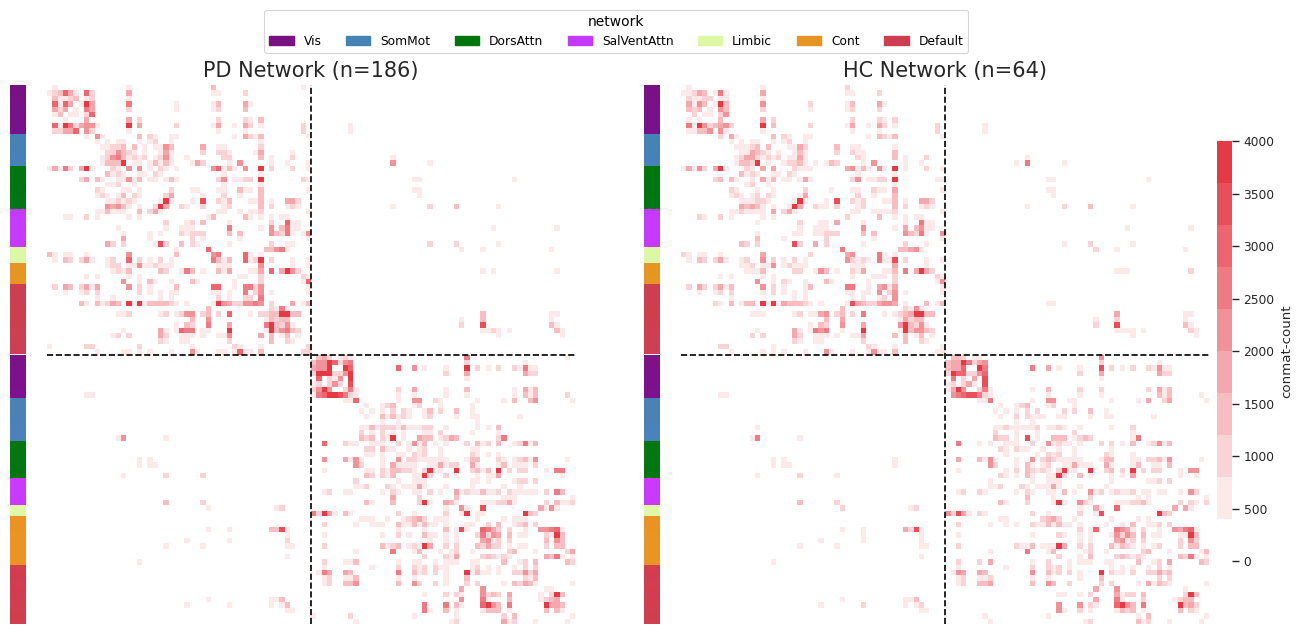

In [9]:
save_fig = True

n_color_bins = 10
max_color = '#e63946'

cmap = LinearSegmentedColormap.from_list('', ['white', max_color], n_color_bins)
# cmap = sns.color_palette("Reds") #,20) #"Greys"
row_colors = network_regions_df["color"]

legend_TN = [mpatches.Patch(color=c, label=l) for c,l in network_regions_df[['color','network']].drop_duplicates("network").values]
midline_idx = PD_network_df.shape[0]//2

with sns.axes_style("white"):
    sns.set_context("paper")
    fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(15, 7))
    cbar_ax = fig.add_axes([.905, .2, .01, .6])

    # -------------------------------------------------------------------------------------#
    # PD
    # -------------------------------------------------------------------------------------#
    plot_df = PD_network_df.copy()
    ax = axes[0]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, cbar=False) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"PD Network (n={n_available_PD})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')
   
    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))

    # -------------------------------------------------------------------------------------#
    # HC
    # -------------------------------------------------------------------------------------#
    plot_df = HC_network_df.copy()
    ax = axes[1]
    g = sns.heatmap(plot_df, square=False, xticklabels=False, yticklabels=False, cmap=cmap, ax=ax, 
                    cbar_kws= {'label': 'conmat-count'},cbar_ax=cbar_ax) #cbar_kws={"shrink": .5}
    g.set_xticklabels(g.get_xticklabels(), rotation=0)
    ax.set_title(f"HC Network (n={n_available_HC})",fontsize=15)
    ax.axhline(y=midline_idx, color='k', linestyle='--')
    ax.axvline(x=midline_idx, color='k', linestyle='--')

    for i, color in enumerate(row_colors):
        g.add_patch(plt.Rectangle(xy=(-0.07, i), width=0.03, height=1, color=color, lw=0,
                                transform=g.get_yaxis_transform(), clip_on=False))
    
l2=g.legend(loc='center left',bbox_to_anchor=(-0.8,1.1),ncol=7, handles=legend_TN,frameon=True) #(1.01,0.9)
l2.set_title(title='network',prop={'size':10})

# plt.tight_layout()

if save_fig:
    plt.savefig(f"{figs_dir}/{atlas}_{desc}.png")

### Test code for FA, MD calculation per ROI

In [26]:
# Network regions
atlas = "Schaefer2018"
desc = "100Parcels7Networks"

network_regions = f"{tractflow_network_extract_dir}/atlas-{atlas}_desc-{desc}_dseg.tsv"

network_regions_df = pd.read_csv(network_regions, sep="\t")
print(f"network_regions_df.shape: {network_regions_df.shape}")
network_regions_df[["n_regions", "hemi", "network", "network_index"]] = network_regions_df["name"].str.split("_",n=3,expand=True)
network_regions_df.head()

network_regions_df.shape: (100, 3)


,index,name,color,n_regions,hemi,network,network_index
0,1,7Networks_LH_Vis_1,#781283,7Networks,LH,Vis,1
1,2,7Networks_LH_Vis_2,#781284,7Networks,LH,Vis,2
2,3,7Networks_LH_Vis_3,#781285,7Networks,LH,Vis,3
3,4,7Networks_LH_Vis_4,#781287,7Networks,LH,Vis,4
4,5,7Networks_LH_Vis_5,#781288,7Networks,LH,Vis,5


In [27]:
def get_roi_measures(measure_file, mask_file):
    """ Get mean measure for each ROI in mask file"""
    
    measure_img = nib.load(measure_file)
    mask_img = nib.load(mask_file)
    mask_data = mask_img.get_fdata()
    measure_data = measure_img.get_fdata()
    n_regions = int(mask_data.max())
    roi_values = []
    roi_range = range(1,n_regions+1)
    for i in roi_range:
        roi_values.append(measure_data[mask_data==i].mean())

    roi_measures_df = pd.DataFrame(columns=["measure"], data=roi_values)
    roi_measures_df["ROI_id"] = roi_range

    return roi_measures_df

### Identify available participants

In [29]:
avaialble_PD_participant_list = []
available_HC_participant_list = []
missing_participants = []

for participant_id in all_participants:
    bids_id = f"sub-{participant_id}"

    mask_file = f"{tractflow_network_extract_dir}/{bids_id}/{session}/anat/{bids_id}_ses-01_space-dwi_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.nii.gz"
    md_measure_file = f"{tractoflow_DTI_metrics_dir}/{bids_id}__md.nii.gz"
    fa_measure_file = f"{tractoflow_DTI_metrics_dir}/{bids_id}__fa.nii.gz"
        
    if Path(mask_file).is_file() & Path(md_measure_file).is_file() & Path(fa_measure_file).is_file():        
        if participant_id in PD_participants:
            avaialble_PD_participant_list.append(participant_id)
        elif participant_id in control_participants:
            available_HC_participant_list.append(participant_id)
        else:
            print(f"Participant {participant_id} not in PD or HC group")
    else:
        missing_participants.append(participant_id)
        # print(f"File(s) not found for: {participant_id}")
    
        
print(f"n missing participants: {len(missing_participants)}")
print(f"available participants: HC:{len(available_HC_participant_list)}, PD:{len(avaialble_PD_participant_list)}")

n missing participants: 64
available participants: HC:52, PD:147


In [30]:
subject_roi_measure_df = pd.DataFrame()

for participant_id in avaialble_PD_participant_list + available_HC_participant_list:
    bids_id = f"sub-{participant_id}"
    
    mask_file = f"{tractflow_network_extract_dir}/{bids_id}/ses-01/anat/{bids_id}_ses-01_space-dwi_atlas-Schaefer2018_desc-100Parcels7Networks_dseg.nii.gz"

    for metric in ["fa", "md"]:
        measure_file = f"{tractoflow_DTI_metrics_dir}/{bids_id}__{metric}.nii.gz"
        roi_measures_df = get_roi_measures(measure_file, mask_file)

        roi_measures_df["participant_id"] = participant_id
        roi_measures_df["metric"] = metric
        subject_roi_measure_df = pd.concat([subject_roi_measure_df, roi_measures_df], axis=0)

### Make plots

In [31]:
plot_df = subject_roi_measure_df.merge(network_regions_df, left_on="ROI_id", right_on="index")
# plot_df["participant_id"] = plot_df["bids_id"].apply(lambda x: x.split("-")[1])
plot_df.loc[:,"group"] = plot_df["participant_id"].apply(lambda x: "PD" if x in avaialble_PD_participant_list else "HC")
plot_df = plot_df.groupby(["network","metric","participant_id","hemi","group"])["measure"].mean().reset_index()

# scale md to um^2/s
plot_df.loc[plot_df["metric"]=="md", "measure"] = plot_df.loc[plot_df["metric"]=="md", "measure"]*1000
plot_df["metric"] = plot_df["metric"].replace({"fa":"Fractional Anisotropy (FA)", "md":"Mean Diffusivity (MD)"})
plot_df.head()

,network,metric,participant_id,hemi,group,measure
0,Cont,Fractional Anisotropy (FA),MNI0068,LH,PD,0.176295
1,Cont,Fractional Anisotropy (FA),MNI0068,RH,PD,0.157747
2,Cont,Fractional Anisotropy (FA),MNI0143,LH,HC,0.153367
3,Cont,Fractional Anisotropy (FA),MNI0143,RH,HC,0.139908
4,Cont,Fractional Anisotropy (FA),MNI0144,LH,HC,0.191704


Check unit for MD


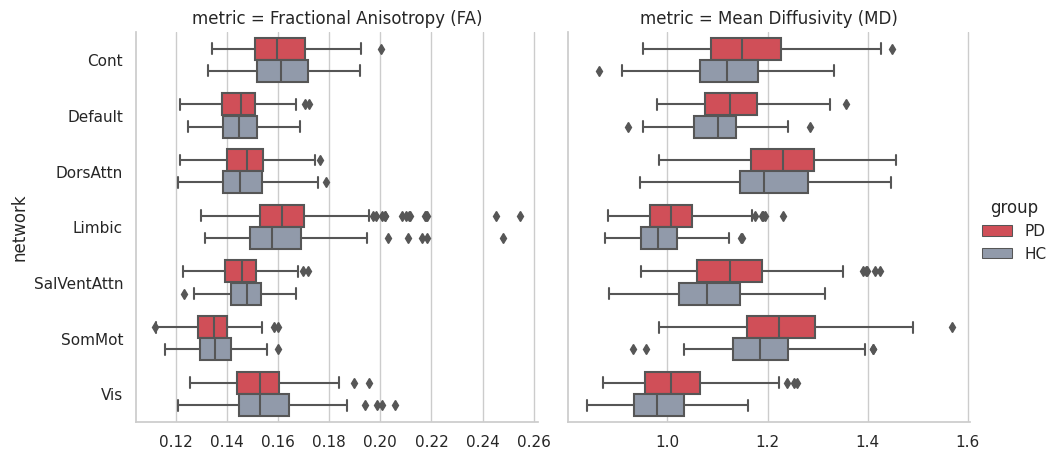

In [32]:
save_fig = True

sns.set_theme(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="measure", y="network", hue="group", kind="box", col="metric", #col_wrap=1,
                    data=plot_df, aspect=1, height=5, sharex=False, palette=QPN_Dx_palette)
    g.set_xlabels("")
    # g.set_xticklabels("")

print(f"Check unit for MD")

if save_fig:
    g.savefig(f"{figs_dir}/DTI_metrics.png")